$$
\textit{Computação Quântica - 2019/2020}\\
\textbf {Implementation of quantum cheque in IBM Quantum Experience}\\
\begin{align*}
\text{Tomás Sousa } &|| \text{ Marco Barbosa}\\
\text{A81411 } &|| \text{ A81428}
\end{align*}
$$

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.constants import pi
import math

# importing Qiskit
import qiskit
from qiskit import IBMQ, Aer
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute

from qiskit.providers.aer.noise import NoiseModel

# import basic plot tools

from qiskit.tools.visualization import plot_histogram, plot_circuit_layout

from qiskit.providers.ibmq import least_busy

from qiskit.compiler import transpile

import warnings
warnings.filterwarnings('ignore')

In [10]:
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [74]:
# Plot results
def show_results(D):
    # D is a dictionary with classical bits as keys and count as value
    # example: D = {'000': 497, '001': 527}
    
    plt.bar(range(len(D)), list(D.values()), align='center')
    plt.xticks(range(len(D)), list(D.keys()))
    plt.show()
    print(D)
    zero = 0
    one = 0
    for r in D:
        if(r[1]=='0'):
            zero += D[r]
        else: 
            one += D[r]
    print("Zero" + str(zero/8192))
    print("One" + str(one/8192))

# Execute circuit, display a histogram of the results
def execute_locally(qc, draw_circuit=False):
    # Compile and run the Quantum circuit on a simulator backend
    backend_sim = Aer.get_backend('qasm_simulator')
    job_sim = execute(qc, backend_sim, shots=8192)
    result_sim = job_sim.result()
    result_counts = result_sim.get_counts(qc)
    
    # Print the results
    print("simulation: \n\n", result_counts)
    show_results(result_counts)
    

def execute_locally_noisy(qc, backend, draw_circuit=False):
    # Compile and run the Quantum circuit on a simulator backend
    noise = NoiseModel.from_backend(backend)
    basis_gates = noise.basis_gates
    cmap = backend.configuration().coupling_map
    backend_sim = Aer.get_backend('qasm_simulator')
    job_sim = execute(qc, backend_sim, shots=8192,
                                                  noise_model=noise,
                                                  coupling_map=cmap,
                                                  basis_gates = basis_gates)
    result_sim = job_sim.result()
    result_counts = result_sim.get_counts(qc)
    
    # Print the results
    print("simulation: \n\n", result_counts)
    show_results(result_counts)

In [59]:
provider = IBMQ.get_provider(hub='ibm-q-minho', group='academicprojects', project='quantalab')
backend = provider.get_backend('ibmq_johannesburg')
print (backend);

### Protocol phases

#### Generation

In [15]:
def generator(qc,qr,cr):
    qc.h(qr[0])
    qc.cx(qr[0],qr[1])
    qc.cx(qr[0],qr[2])

#### Sign

In [41]:
def sign(qc,qa,qr,k,id,r,M):
    max = 32
    step = 2*pi/max
    rotations = hash(k+id+r+M) % max
    qc.h(qa[0])
    qc.u1(rotations*step,qa[0])
    qc.barrier()
    qc.cx(qa[0],qr[0])
    qc.h(qa[0])
    qc.cx(qr[0],qr[1])
    qc.cz(qa[0],qr[1])
    qc.barrier()
    

#### Verification

In [97]:
def verify(qc,qr,qb,k,id,r,M):
    max = 32
    step = 2*pi/max
    rotations = hash(k+id+r+M) % max
    qc.h(qr[2])
    qc.cz(qr[2],qr[1])
    qc.barrier()
    qc.h(qb[0])
    qc.u1(rotations*step,qb[0])
    qc.h(qb[1])
    qc.cswap(qb[1],qb[0],qr[1])
    qc.h(qb[1])
    qc.barrier()

In [98]:
def measure():
    cheque.measure(qb[1],cb[0])  

#### Circuit construction

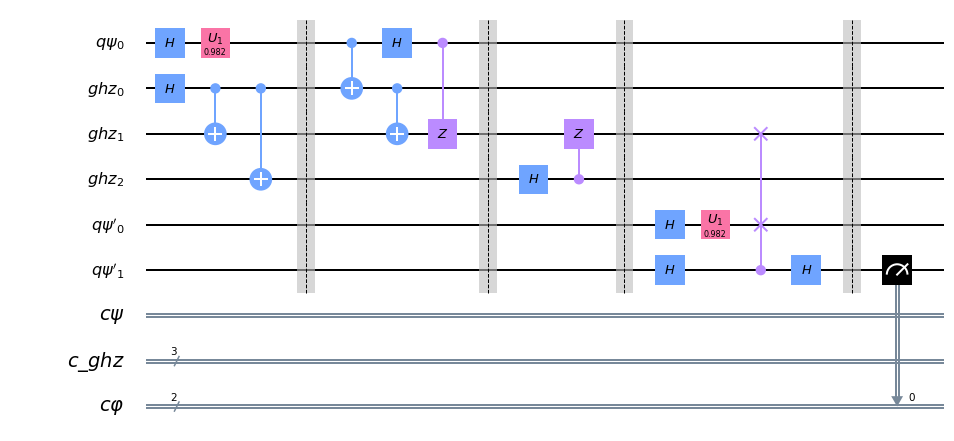

In [79]:
qr = QuantumRegister(3,'ghz')
qa = QuantumRegister(1,'q  ''\u03C8')
qb = QuantumRegister(2,'q  \u03C8\'')
cr = ClassicalRegister(3,'c\_ghz')
ca = ClassicalRegister(1,'c \u03C8')
cb = ClassicalRegister(2,'c \u03C6')
cheque = QuantumCircuit(qa,qr,qb,ca,cr,cb)
generator(cheque,qr,cr)
sign(cheque,qa,qr,"a","b","c","d")
verify(cheque,qr,qb,"a","b","c","d")
measure()
cheque.draw(output='mpl')

### Execution

#### Simulator

simulation: 

 {'00 000 0': 8192}


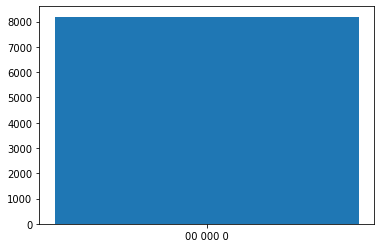

{'00 000 0': 8192}
Zero1.0
One0.0


In [50]:
execute_locally(cheque)

#### Simulator with noise model of IBMq-Johannesburg

simulation: 

 {'00 000 0': 7197, '01 000 0': 995}


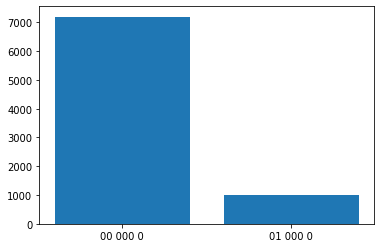

{'00 000 0': 7197, '01 000 0': 995}
Zero0.8785400390625
One0.1214599609375


In [88]:
execute_locally_noisy(cheque_exp,backend)

#### IBMq-Johannesburg

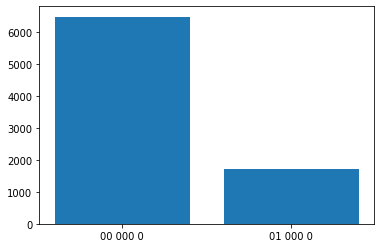

{'00 000 0': 6479, '01 000 0': 1713}
Zero0.7908935546875
One0.2091064453125


In [55]:
job = execute(cheque,backend, shots=8192)
D = job.result().get_counts()
show_results(D)